# **Capitulo 6 – Ensemble Learning and Random Forests**

# Setup

Como hicimos en NoteBooks anteriores, vamos a definir los tamaños de fuente por defecto para que las figuras queden más bonitas:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Y vamos a crear la carpeta `images/ensembles` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este Notebook para guardar las figuras:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

# Stacking

El último método de ensemble que analizaremos en este notebook se denomina stacking (abreviatura de stacked generalization, generalización apilada) Se basa en una idea sencilla: en lugar de utilizar funciones triviales (como el hard voting) para agregar las predicciones de todos los predictores de un ensemble, ¿por qué no entrenamos un modelo para que realice esta agregación? La figura muestra un conjunto de este tipo realizando una tarea de regresión sobre una nueva instancia. Cada uno de los tres predictores inferiores predice un valor diferente (3,1, 2,7 y 2,9) y, a continuación, el predictor final (llamdo blender, o meta learner) toma estas predicciones como entradas y realiza la predicción final (3,0).

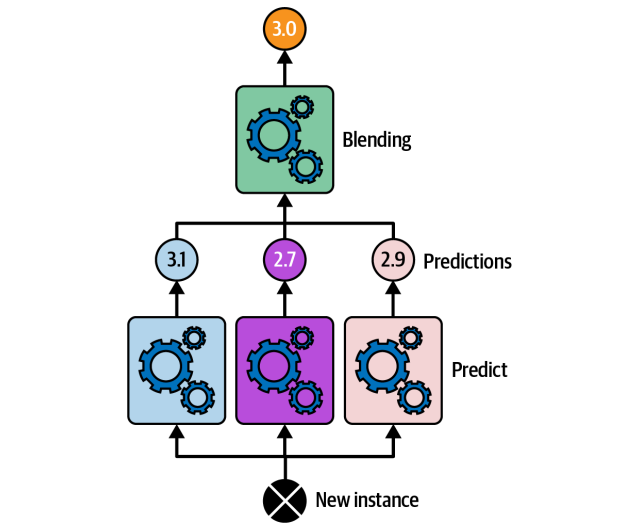

Para entrenar el blender, primero hay que construir el conjunto de entrenamiento de mezclado. Puede utilizar cross_val_predict() en cada predictor del conjunto para obtener predicciones fuera de muestra para cada instancia del conjunto de entrenamiento original, y utilizarlas como características de entrada para entrenar el blender; y los objetivos pueden copiarse simplemente del conjunto de entrenamiento original. Tenga en cuenta que, independientemente del número de características del conjunto de entrenamiento original (sólo una en este ejemplo), el conjunto de entrenamiento del blender contendrá una característica de entrada por predictor (tres en este ejemplo). Una vez entrenado el blemder, los predictores base se vuelven a entrenar una última vez en el conjunto de entrenamiento original completo.

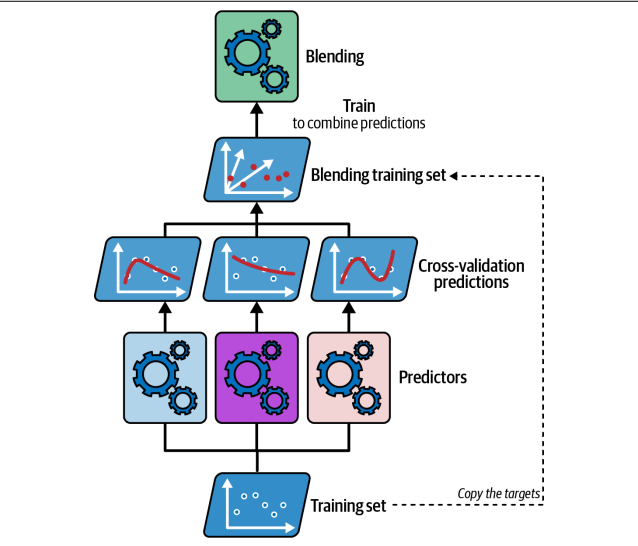


De hecho, es posible entrenar varios blenders diferentes de esta manera (por ejemplo, uno usando regresión lineal, otro usando regresión de random forest) para obtener una capa completa de blenders, y luego añadir otro blender encima para producir la predicción final, como se muestra en la Figura. Es posible que pueda exprimir algunas décimas más de rendimiento haciendo esto, pero le costará tanto en tiempo de entrenamiento como en complejidad del sistema.

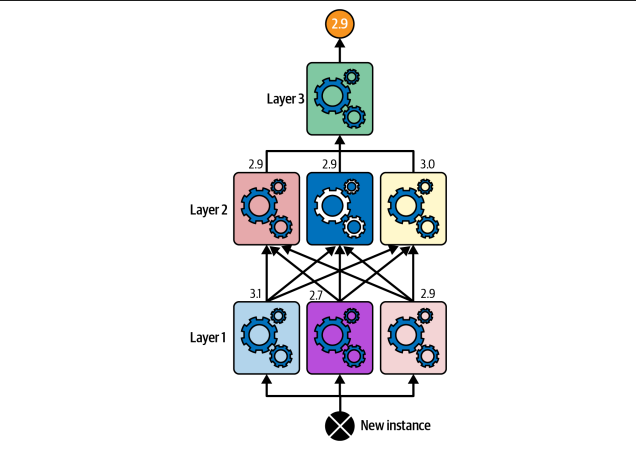

Scikit-Learn proporciona dos clases para stacking ensembles: StackingClassifier y StackingRegressor. Por ejemplo, podemos sustituir el VotingClassifier que utilizamos al principio de este notebook en el conjunto de datos de lunas por un StackingClassifier:

In [38]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [39]:
stacking_clf.score(X_test, y_test)

0.928

Para cada predictor, el stacking clasificador llamará a predict_proba() si está disponible; si no, volverá a decision_function() o, como último recurso, llamará a predict(). Si no se proporciona un estimador final, StackingClassifier utilizará LogisticRegression y StackingRegressor utilizará RidgeCV.

Si evalúa este modelo de stacking en el conjunto de pruebas, encontrará una precisión del 92,8%, que es un poco mejor que la del clasificador por el soft voting, que obtuvo un 92%.

En conclusión, los métodos ensemble son versátiles, potentes y bastante sencillos de utilizar. Los Random Forest, AdaBoost y GBRT se encuentran entre los primeros modelos que debería probar para la mayoría de las tareas de aprendizaje automático, y brillan especialmente con datos tabulares heterogéneos. Además, como requieren muy poco preprocesamiento, son ideales para poner en marcha rápidamente un prototipo. Por último, los métodos de ensamblaje, como los clasificadores voting y los clasificadores stacking, pueden ayudar a llevar al límite el rendimiento del sistema.
